# Practico Clustering - Text Mining 2021

Garagiola, Nazareno

Clustering is the process of grouping a set of documents into clusters of similar documents


## Requerimientos

In [1]:
import spacy
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold
from collections import Counter
%matplotlib inline

In [2]:
!python3 -m spacy download es_core_news_md > trash.txt
#!python3 -m spacy download es_core_news_sm



---



In [136]:
f = open("lavoztextodump.txt", 'r')
text = f.read()[:1000000] #[:1000000] 
text = text.replace('"', '')
text = text.replace('-\n', '\n')

In [137]:
# antes de correr esto, hay que correr la instalacion y resetear el runtime
nlp = spacy.load("es_core_news_md", vectores=False, entity=False)

lemmas = []
words = []
doc = nlp(text)
for token in doc:
    if len(token) > 1 and token.is_alpha: #alfabeticos e ignoro puntuaciones
        lemmas.append(token.lemma_.lower())
        words.append(token.text.lower())


Si están trabajando en Colab, es normal que al hacer el load de Spacy aparezca un error.

**`ModuleNotFoundError: No module named 'es_core_news_md'`**.

Reinicien el Kernel/Runtime (usen el menú de arriba o el botón en la notebook), salteen la celda de instalación (la de abajo) y ejecuten la celda previa de vuelta. 

    `!python3 -m spacy download es_core_news_md > trash.txt`


## Preprocesamiento

-> Preproceso: Lemmatizacion, catergoria morfosintactica (POS), etc

-> Hacer diferentes aproximacione spara categorizar palabras, por contexto en diferentes tamaños de ventanas

In [138]:
counter_lemma = Counter(lemmas)
counter_words = Counter(words) #tambien se podria usar este

Las triplas de dependencias son una forma de representar relaciones entre palabras. Si tengo una oración como "El gato come pescado", el análisis sintáctico de esa oración me dirá que gato es sujeto de comer, pescado es objeto de comer. Entonces, puedo representar la palabra gato diciendo que ocurrió una vez en el contexto X - sujeto - comer, y la palabra pescado diciendo que ocurrió una vez en el contexto X - objeto - comer. Entonces, mis dimensiones son estas triplas de la forma "Palabra objetivo - Función sintáctica - Otra palabra"

In [184]:
#most frequent words
MIN_FREQ = 30
#most_freq = []
#for l in counter_lemma:
#    if (counter_lemma[l] >= MIN_FREQ):
#        most_freq.append(l)
#print(f"amount of lemmas that appear more than {MIN_FREQ} times: {len(most_freq)}")

def word_filter(token):
    """
    Pequeña funcion que usaremos para filtrar las palabras
    """
    return (not token.is_alpha or token.is_digit or not counter_lemma[token.lemma_] >= MIN_FREQ)


In [185]:
triplas = {}
tag = {}
pos = {}
close_context = {}
large_context = {}

for token in doc:
    if word_filter(token): continue
    triplas[token.lemma_] = {}
    tag[token.lemma_] = {}
    pos[token.lemma_] = {}


    close_context[token.lemma_] = {}
    large_context[token.lemma_] = {}



In [186]:
for token in doc:
    if word_filter(token): continue

    i = token.i
    word = token.lemma_.lower()
    # Cargo part of speech de cada palabra
    if not token.pos_ in pos[word].keys():
        pos[word][token.pos_] = 0
    pos[word][token.pos_] += 1

    # Cargo tag de cada palabra
    if not token.tag_ in tag[word].keys():
        tag[word][token.tag_] = 0
    tag[word][token.tag_] += 1


    #contextos inmediatos
#    if not i == 0:
#        lft = doc[i - 1]
#        c_izq = lft.lemma_
#        if lft.is_digit:
#            c_izq = "NUM__"
#        if lft.is_alpha: # and counter_lemma[c_izq] > threshold_c:
#            if not c_izq in context_lft[word].keys():
#                context_lft[word][c_izq] = 0
#            context_lft[word][c_izq] += 1
#
#     if not i == len(doc) - 1:
#        rgt = doc[i + 1]
#        c_der = rgt.lemma_
#        if rgt.is_digit:
#            c_der = "NUM__"
#        if rgt.is_alpha: # and counter_lemma[c_der] > threshold_c:
#            if not c_der in context_rgt[word].keys():
#                context_rgt[word][c_der] = 0
#            context_rgt[word][c_der] += 1


    #Triplas de dependencias, aca dentro porque miro la siguiente si o si
    if not i == len(doc) - 1:
        tripla = (f"obj: {word} - dep : {token.dep_} - root: {doc[i+1].head.lemma_}") # - context: {span}")
        if not tripla in triplas[word].keys():
            triplas[word][tripla] = 0
        triplas[word][tripla] += 1




---



In [159]:
with open("stopwords.txt",'r') as f:
    stopwords = f.read().split('\n')

def not_a_stopword(token):
    """
    Funcion que toma un token de Spacy y revisa que su lemma sea o on una 
    stopword en español
    """
    return (token.is_alpha and (not token.lemma_.lower() in stopwords))


def immediate_related_words(span):
    tokens = list(filter(not_a_stopword, doc[close_lft:close_rgt]))
    return list(map(lambda token: token.lemma_, tokens))

def keywords_in(span):
    tokens = list(filter(
        lambda token: not word_filter(token) and not_a_stopword(token), span))
    return list(map(lambda token: token.lemma_, tokens))


In [187]:
close_window, large_window = 5, 20
for token in doc:
    if word_filter(token): continue
    i = token.i
    lemma = token.lemma_.lower()
    # las que esten a una disntacia de 5, sin stopwords, las agrego al context total
    # las que esten a una distancia de 20, agrego solo las roots
    close_lft, close_rgt = i-close_window, i+close_window

    if not close_lft <= 0 and close_rgt >= len(doc):
        imm_related_words = immediate_related_words(doc[close_lft:close_rgt])
        for word in imm_related_words:
            if not word in close_context[lemma].keys():
                close_context[lemma][word] = 0
            close_context[lemma][word] += 1

    large_lft, large_rgt = i-large_window, i+large_window
    if not large_lft <= 0 and large_rgt >= len(doc):
        keywords_in_context = keywords_in(doc[large_lft: large_rgt])
        for word in keywords_in_context:
            if not word in large_context[lemma].keys():
                large_context[lemma][word] = 0
            large_context[lemma][word] += 1


In [ ]:
close_context



---



In [188]:
feats = {}
for token in doc:
    if word_filter(token): continue
    word = token.lemma_
    feats[word] = {**tag[word], **pos[word], **triplas[word], **large_context[word], **close_context[word]}

## Vectorización

Ahora comenzamos a trabajr con los datos luego de que esten preprocessados

In [189]:
from sklearn.feature_extraction import DictVectorizer
# the class DictVectorizer can be used to convert feature arrays represented as 
# lists of standard Python dict objects to the NumPy/SciPy representation used
# by scikit-learn estimators.
vec = DictVectorizer(sparse=False)
features = []
key_words = {}
wid = 0
for word in feats:
    key_words[word] = wid
    wid += 1
    features.append(feats[word])
matrix = vec.fit_transform(X=features)


In [190]:
matrix_normed = matrix / matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

THRESHOLD_VARIANCES = 0.001 #
red_matrix = np.delete(matrix_normed, np.where(variances < THRESHOLD_VARIANCES), axis=1)

print(matrix.shape, matrix_normed.shape, red_matrix.shape)

(623, 60116) (623, 60116) (623, 60116)


## Clustering

In [191]:
from nltk.cluster import kmeans, cosine_distance
#from sklearn.cluster import KMeans
#from sklearn import preprocessing

def clustering(k, matrix):
    """
    k -> Cantidad de clusterers
    """
    clusterer = kmeans.KMeansClusterer(num_means=k, distance=cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix, True)

    #kmeans = KMeans(n_clusters=k).fit(preprocessing.normalize(matrix))
    #clusterer = KMeans(n_clusters=k)
    #kmeans.fit(matrix)
    return clusters

In [192]:
NUM_CLUSTERS = 30
cluster =  clustering(NUM_CLUSTERS, matrix_normed)

In [193]:
#printer
for i in range(NUM_CLUSTERS):
    printer = [token for token in key_words if cluster[key_words[token]]==i]
    print(f"Cluser {i}:\n {printer}")


Cluser 0:
 ['lo', 'el', 'se', 'sino', 'les', 'pero', 'me', 'los', 'ninguno', 'si', 'qué', 'aunque', 'institución', 'porque', 'alguno', 'le', 'su', 'nosotros', 'ellos', 'donde', 'quien', 'yo', 'él', 'nuestro', 'vario', 'mi', 'cómo', 'cual', 'mientras', 'aquel', 'nadie', 'varios', 'cuyo']
Cluser 1:
 ['diferenciar']
Cluser 2:
 ['colegio', 'centro', 'caso', 'kilómetro', 'dato', 'comercio', 'trabajo', 'hecho', 'precio', 'millón', 'cargo', 'voto', 'gobierno']
Cluser 3:
 ['gracia']
Cluser 4:
 ['alrededor']
Cluser 5:
 ['parejo', 'casar', 'hijo', 'mujer', 'vez', 'comer', 'personar', 'coser', 'dudar', 'vida', 'manera', 'formar', 'medir', 'reformar', 'ley', 'obrar', 'escuela', 'forzar', 'posibilidad', 'familia', 'contar', 'aguar', 'mesar', 'noche', 'discusión', 'seguridad', 'mirar', 'causar', 'protestar', 'cuestión', 'infraestructura', 'calidad', 'proponer', 'participación', 'clase', 'sobrar', 'información', 'chico', 'preguntar', 'mañana', 'plantar', 'situación', 'profesor', 'plaza', 'respuesta',

In [194]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, n_iter=500) #ultimo param para que sea mas rapido
reduced_data = tsne.fit_transform(red_matrix)
reduced_data.shape

(623, 2)



---



In [ ]:

#from gensim.models.keyedvectors import KeyedVectors
#wordvectors_file_vec = 'fasttext-sbwc.3.6.e20.vec'
#cantidad = 100000
#wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)



---



In [195]:
aux = [(reduced_data[i], cluster[i], list(key_words.keys())[i]) for i in range(wid)]

df_clustered = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in aux],
    columns=["dim1", "dim2", "cluster", "word"]
)

In [196]:
df_clustered.head(12)

,dim1,dim2,cluster,word
0,-3.486666,-1.606278,26,que
1,26.032471,41.081249,8,sostener
2,-0.597063,0.942119,0,lo
3,-7.578181,31.245062,5,parejo
4,3.584965,6.297052,26,ser
5,1.514896,2.713315,0,el
6,-5.320522,0.822581,14,no
7,-1.575621,-3.828439,0,se
8,57.198891,64.471397,13,unir
9,-23.010143,17.741329,26,sin


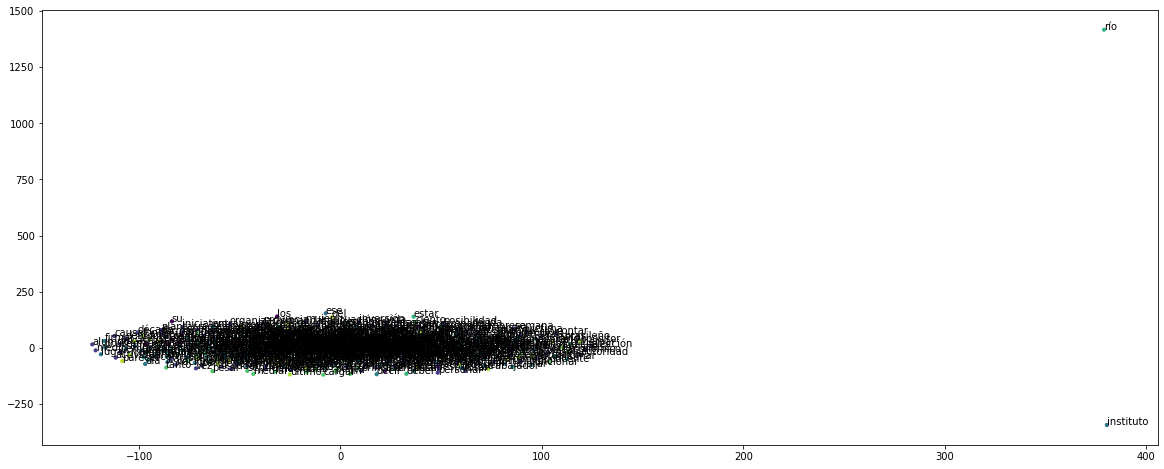

In [197]:
plt.figure(figsize=(20, 8))
plt.scatter(x=df_clustered['dim1'],y=df_clustered['dim2'], s=10, c=df_clustered['cluster'])
for i in range(wid):
    plt.annotate(df_clustered['word'][i], (df_clustered['dim1'][i], df_clustered['dim2'][i]))

plt.show()